In [13]:
import os
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Download NLTK resources (only needs to be done once)
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/i538819/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/i538819/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Preprocessing + Embeddings

In [2]:
def simple_preprocess(text):
    if not isinstance(text, str):
        text = ""
    return word_tokenize(text.lower())

In [3]:
def average_embedding(tokens, model):
    vectors = [model[word] for word in tokens if word in model]
    if not vectors:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

## Feature Extractors

In [4]:
def extract_title_features(row, model):
    tokens1 = simple_preprocess(row['title1'])
    tokens2 = simple_preprocess(row['title2'])

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_text_features(row, model):
    tokens1 = simple_preprocess(row['text1'])
    tokens2 = simple_preprocess(row['text2'])

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_combined_features(row, model):
    t1 = f"{row['title1']} {row['text1']}"
    t2 = f"{row['title2']} {row['text2']}"
    tokens1 = simple_preprocess(t1)
    tokens2 = simple_preprocess(t2)

    vec1 = average_embedding(tokens1, model)
    vec2 = average_embedding(tokens2, model)

    sim = cosine_similarity([vec1], [vec2])[0][0]
    diff = np.abs(vec1 - vec2)
    prod = vec1 * vec2

    return [sim] + diff.tolist() + prod.tolist()

def extract_all_features(row, model):
    structured_cols = ['geography', 'entities', 'time', 'narrative', 'style', 'tone']
    # --- Title vector ---
    tokens_title1 = simple_preprocess(row['title1'])
    tokens_title2 = simple_preprocess(row['title2'])
    vec_title1 = average_embedding(tokens_title1, model)
    vec_title2 = average_embedding(tokens_title2, model)
    sim_title = cosine_similarity([vec_title1], [vec_title2])[0][0]
    diff_title = np.abs(vec_title1 - vec_title2)
    prod_title = vec_title1 * vec_title2

    # --- Text vector ---
    tokens_text1 = simple_preprocess(row['text1'])
    tokens_text2 = simple_preprocess(row['text2'])
    vec_text1 = average_embedding(tokens_text1, model)
    vec_text2 = average_embedding(tokens_text2, model)
    sim_text = cosine_similarity([vec_text1], [vec_text2])[0][0]
    diff_text = np.abs(vec_text1 - vec_text2)
    prod_text = vec_text1 * vec_text2

    # --- Structured features ---
    structured = [row[col] for col in structured_cols]

    # --- Final feature vector ---
    return (
        [sim_title] + diff_title.tolist() + prod_title.tolist() +
        [sim_text] + diff_text.tolist() + prod_text.tolist() +
        structured
    )


## Classification Train/Evaluate Function

In [15]:
def run_classification(df, feature_func, model, description):
    print(f"\n=== Running classification on: {description} ===")

    # Extract features
    X = []
    y = []
    for _, row in df.iterrows():
        X.append(feature_func(row, model) if model else feature_func(row))
        y.append(row["overall_classification"])

    X = np.array(X)
    y = np.array(y)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train classifier
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall: {rec:.3f}")
    print(f"F1 Score: {f1:.3f}")

    # print("Classification Report:")
    # print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {description}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return {
        "Model": description,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

## Classification with Word2Vec

Loading CSV...
Loading Word2Vec model ...

=== Running classification on: Title Only - Word2Vec ===
Accuracy: 0.536
Precision: 0.416
Recall: 0.536
F1 Score: 0.428


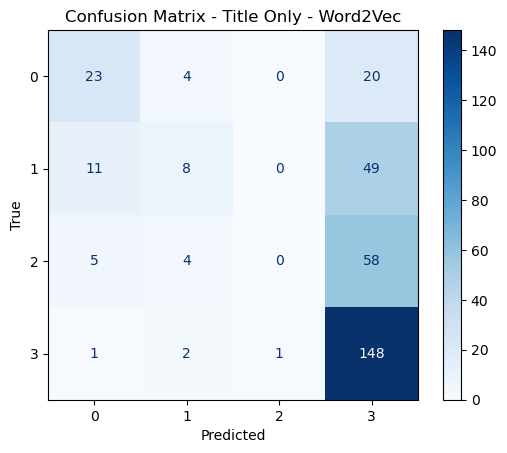


=== Running classification on: Text Only - Word2Vec ===
Accuracy: 0.536
Precision: 0.486
Recall: 0.536
F1 Score: 0.459


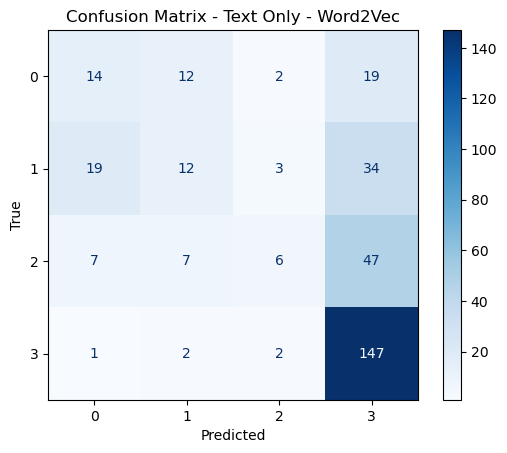


=== Running classification on: Title + Text - Word2Vec ===
Accuracy: 0.542
Precision: 0.475
Recall: 0.542
F1 Score: 0.462


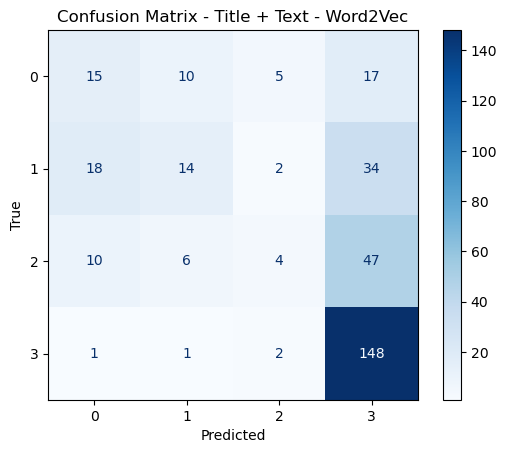


=== Running classification on: All Features - Word2Vec ===
Accuracy: 0.656
Precision: 0.634
Recall: 0.656
F1 Score: 0.593


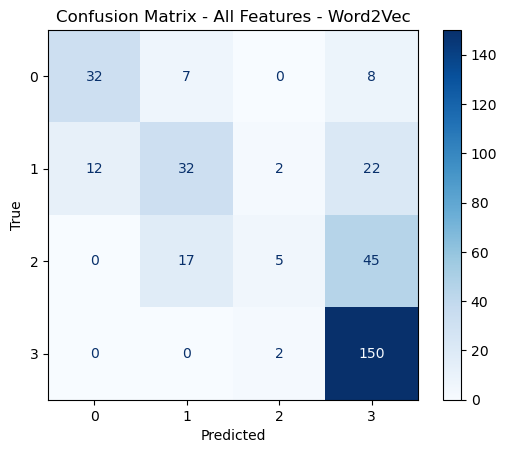

In [16]:
# Load CSV with all pairs
print("Loading CSV...")
df = pd.read_csv("data/full_dataset.csv")

# Filter for English-only pairs
df = df[(df["lang1"] == "en") & (df["lang2"] == "en")].reset_index(drop=True)

# Load pre-trained Word2Vec model (Google News vectors)
print("Loading Word2Vec model ...")
model = KeyedVectors.load_word2vec_format("pretrained_models/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

results = []

results.append(run_classification(df, extract_title_features, model, "Title Only - Word2Vec"))
results.append(run_classification(df, extract_text_features, model, "Text Only - Word2Vec"))
results.append(run_classification(df, extract_combined_features, model, "Title + Text - Word2Vec"))
results.append(run_classification(df, extract_all_features, model, "All Features - Word2Vec"))


## Classification with FastText

Loading FastText model...

=== Running classification on: Title Only - FastText ===
Accuracy: 0.500
Precision: 0.419
Recall: 0.500
F1 Score: 0.378


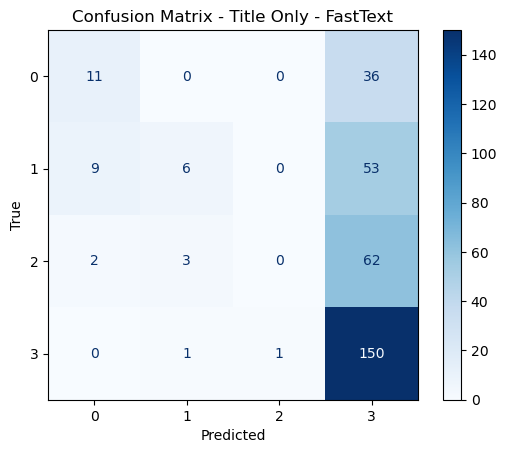


=== Running classification on: Text Only - FastText ===
Accuracy: 0.521
Precision: 0.472
Recall: 0.521
F1 Score: 0.436


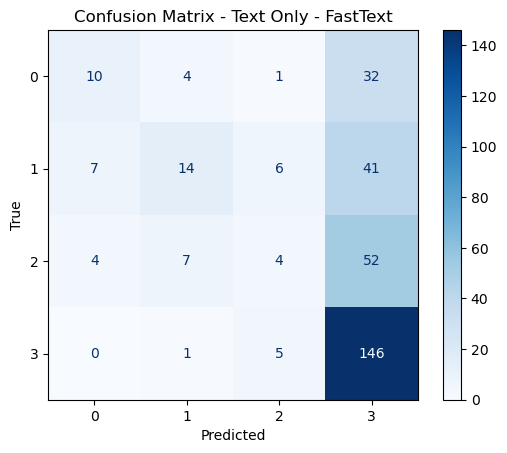


=== Running classification on: Title + Text - FastText ===
Accuracy: 0.497
Precision: 0.420
Recall: 0.497
F1 Score: 0.398


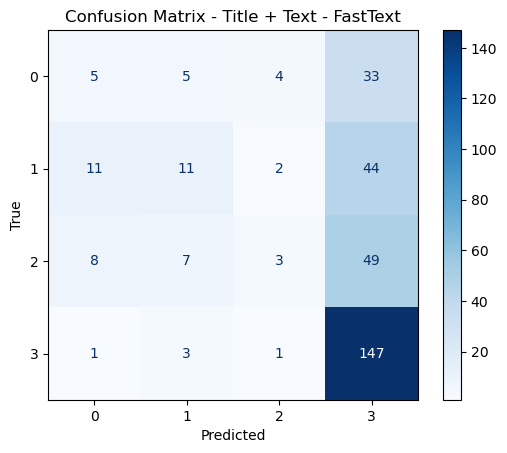


=== Running classification on: All Features - FastText ===
Accuracy: 0.644
Precision: 0.606
Recall: 0.644
F1 Score: 0.579


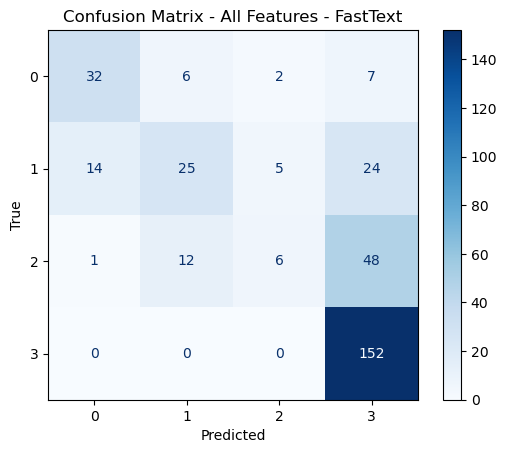

In [17]:
# Load FastText word vectors
print("Loading FastText model...")
if os.path.exists("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv"):
    model2 = KeyedVectors.load("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")  # faster loading
else:
    model2 = KeyedVectors.load_word2vec_format("pretrained_models/fasttext/wiki-news-300d-1M-subword.vec")
    model2.save("pretrained_models/fasttext/wiki-news-300d-1M-subword.kv")

results.append(run_classification(df, extract_title_features, model2, "Title Only - FastText"))
results.append(run_classification(df, extract_text_features, model2, "Text Only - FastText"))
results.append(run_classification(df, extract_combined_features, model2, "Title + Text - FastText"))
results.append(run_classification(df, extract_all_features, model2, "All Features - FastText"))


## Classification Word2Vec vs. FastText

In [8]:
# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df.sort_values(by="Model"))


,Model,Accuracy,Precision,Recall,F1 Score
7,All Features - FastText,0.643713,0.606213,0.643713,0.578827
3,All Features - Word2Vec,0.655689,0.633517,0.655689,0.592582
5,Text Only - FastText,0.520958,0.471963,0.520958,0.435519
1,Text Only - Word2Vec,0.535928,0.485511,0.535928,0.458572
6,Title + Text - FastText,0.497006,0.419507,0.497006,0.397640
2,Title + Text - Word2Vec,0.541916,0.475434,0.541916,0.462491
4,Title Only - FastText,0.500000,0.419304,0.500000,0.377573
0,Title Only - Word2Vec,0.535928,0.416320,0.535928,0.427753


## Regression Train/Evaluate

In [9]:
def run_regression(df, feature_func, model, description):
    print(f"\n=== Running classification on: {description} ===")
    X, y = [], []
    for _, row in df.iterrows():
        X.append(feature_func(row, model))
        y.append(row["overall"])
    X = np.array(X)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse:.3f}")
    print(f"Mean Absolute Error: {mae:.3f}")
    print(f"R2 Score: {r2:.3f}")

    return {
        "Model": description,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    }

## Regression with Word2Vec

In [10]:
regression_results = []

regression_results.append(run_regression(df, extract_title_features, model, "Title Only - Word2Vec"))
regression_results.append(run_regression(df, extract_text_features, model, "Text Only - Word2Vec"))
regression_results.append(run_regression(df, extract_combined_features, model, "Title + Text - Word2Vec"))
regression_results.append(run_regression(df, extract_all_features, model, "All Features - Word2Vec"))


=== Running classification on: Title Only - Word2Vec ===
Mean Squared Error: 0.637
Mean Absolute Error: 0.625
R2 Score: 0.430

=== Running classification on: Text Only - Word2Vec ===
Mean Squared Error: 0.582
Mean Absolute Error: 0.593
R2 Score: 0.479

=== Running classification on: Title + Text - Word2Vec ===
Mean Squared Error: 0.543
Mean Absolute Error: 0.571
R2 Score: 0.514

=== Running classification on: All Features - Word2Vec ===
Mean Squared Error: 0.117
Mean Absolute Error: 0.245
R2 Score: 0.896


## Regression with FastText

In [11]:
regression_results.append(run_regression(df, extract_title_features, model2, "Title Only - FastText"))
regression_results.append(run_regression(df, extract_text_features, model2, "Text Only - FastText"))
regression_results.append(run_regression(df, extract_combined_features, model2, "Title + Text - FastText"))
regression_results.append(run_regression(df, extract_all_features, model2, "All Features - FastText"))


=== Running classification on: Title Only - FastText ===
Mean Squared Error: 0.863
Mean Absolute Error: 0.805
R2 Score: 0.227

=== Running classification on: Text Only - FastText ===
Mean Squared Error: 0.824
Mean Absolute Error: 0.746
R2 Score: 0.262

=== Running classification on: Title + Text - FastText ===
Mean Squared Error: 0.809
Mean Absolute Error: 0.743
R2 Score: 0.275

=== Running classification on: All Features - FastText ===
Mean Squared Error: 0.120
Mean Absolute Error: 0.249
R2 Score: 0.892


## Regression Word2Vec vs. FastText

In [12]:
# Convert to DataFrame
regression_results_df = pd.DataFrame(regression_results)
display(regression_results_df.sort_values(by="Model"))


,Model,MSE,MAE,R2
7,All Features - FastText,0.120298,0.248697,0.892250
3,All Features - Word2Vec,0.116648,0.245437,0.895519
5,Text Only - FastText,0.824094,0.746036,0.261864
1,Text Only - Word2Vec,0.581585,0.592546,0.479078
6,Title + Text - FastText,0.809188,0.742919,0.275215
2,Title + Text - Word2Vec,0.542847,0.571476,0.513775
4,Title Only - FastText,0.863359,0.804569,0.226695
0,Title Only - Word2Vec,0.636614,0.624991,0.429788
